In [2]:
import pandas as pd
import numpy as np
from ladybug.epw import EPW
from lightning.pytorch import Trainer
from pathlib import Path

from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from weather.weather import extract


Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
bucket = "ml-for-bem"
remote_experiment = "full_climate_zone/v5"
local_data_dir = "data/lightning"

registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v1"
resource = "model-with-transform-configs.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpkbtr92p5
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpkbtr92p5/_remote_module_non_scriptable.py
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'target_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['target_transform'])`.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'weather_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['weather_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
sin_schedule = np.linspace(0,2*np.pi*365-1/24*2*np.pi,365*24)
sin_schedule = -np.cos(sin_schedule)/2 + 0.5
schedules = np.stack([sin_schedule]*3).reshape(1,3,8760)

In [5]:
epw = EPW("/teamspace/uploads/USA_NY_New.York-LaGuardia.AP.725030_TMYx.2004-2018.epw")
climate = extract(epw)

In [140]:
config = {
    "FacadeMass": 1,
    "RoofMass": 1,
    "FacadeRValue": 3.161,
    "RoofRValue": 3.161,
    "SlabRValue": 3.161,
    "PeopleDensity": 0.025,
    "EquipmentPowerDensity": 6,
    "LightingPowerDensity": 10,
    "HeatingSetpoint": 18,
    "CoolingSetpoint": 24,
    "cop_heating": 1,
    "cop_cooling": 1,
    "VentilationMode": 1,
    "VentilationPerArea": 0.0006,
    "VentilationPerPerson": 0.01,
    "EconomizerSettings": 0,
    "RecoverySettings": 0,
    "Infiltration": 0.0005,
    "wwr": 0.5,
    "WindowUValue": 1.0,
    "WindowShgc": 0.75,
    "template_idx": 0,
    "width": 3,
    "height": 4,
    "floor_2_facade": 0.75,
    "core_2_perim": 1,
    "building_id": 0,
    "weight": 1,
}
for i in range(12):
    config[f"shading_{i}"] = 0
features = pd.DataFrame(data=config, index=[0])
features = pd.concat([features]*12,axis=0)
features["roof_2_footprint"] = [0,0,1]*4
features["ground_2_footprint"] = [1,0,0]*4
features["orientation"] = [*[0]*3,*[1]*3,*[2]*3,*[3]*3]

features.index = range(12)
for i in range(4):
    for j in range(3):
        features.loc[i*3+j,"name"] = f"{['bottom','middle','top'][j]}_{['south','east','north','west'][i]}"
shoebox_results, *_ = predict_ubem(trainer=trainer, surrogate=surrogate, features=features,schedules=schedules, climate=climate,apply_cops=False, batch_size=32,)
# shoebox_results["Perimeter"]["Heating"].sum(axis=1)
# shoebox_results["box_name"] = features["name"]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [143]:
shoebox_results["Perimeter"]["Heating"].sum(axis=1)

building_id    
0            0      4.916034
             1      5.918840
             2     23.927366
             3     23.376926
             4     23.174463
             5     53.240845
             6     45.807434
             7     44.299721
             8     84.692833
             9     25.553888
             10    24.890274
             11    55.425163
dtype: float32

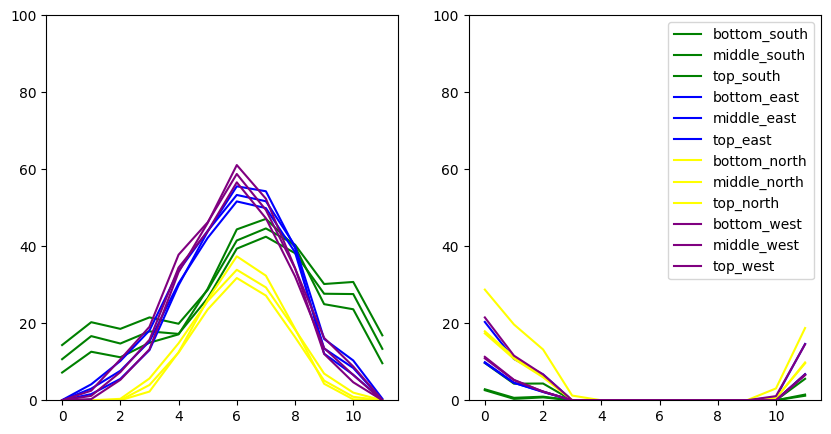

In [141]:
# shoebox_results = shoebox_results.set_index("box_name")
import matplotlib.pyplot as plt
colors = {
    "bottom_south":"green",
    "middle_south": "green",
    "top_south": "green",
    "bottom_east":"blue",
    "middle_east": "blue",
    "top_east": "blue",
    "bottom_north":"yellow",
    "middle_north": "yellow",
    "top_north": "yellow",
    "bottom_west":"purple",
    "middle_west": "purple",
    "top_west": "purple",
}
fig,axs = plt.subplots(1,2,figsize=(10,5))
for i in range(12):
    axs[0].plot(shoebox_results["Perimeter"]["Cooling"].values[i],label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[1].plot(shoebox_results["Perimeter"]["Heating"].values[i],label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
axs[0].set_ylim([0,100])
axs[1].set_ylim([0,100])
plt.legend()